In [16]:
# Importing the libraries needed for our temperature prediction model

import numpy as np                                                            # Helps in numerical calculations
import pandas as pd                                                           # Helps in creating and handling datasets
import matplotlib.pyplot as plt                                               # Used for plotting graphs
import seaborn as sns                                                         # Used for making beautiful charts
from sklearn.model_selection import train_test_split                          # Splits data for training/testing
from sklearn.linear_model import LinearRegression                             # Machine learning model
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score  # To measure model accuracy
import datetime                                                               # To convert input date into day

In [17]:
# -----------------------------------------------------------
# STEP 1: Input data for 1 year from 01-12-2024 to 01-12-2025
# -----------------------------------------------------------

# Create date range for 1 year
dates = pd.date_range(start="2024-12-01", end="2025-12-01", freq="D")
day_numbers = np.arange(1, len(dates)+1)
months = dates.month
month_names = dates.strftime('%b')

# Custom monthly average temperatures (your values)
monthly_avg_temp = {
    1: 16, 2: 21, 3: 25, 4: 29, 5: 31, 6: 33,
    7: 30, 8: 28, 9: 27, 10: 24, 11: 21, 12: 18
}

# Generate daily temperature around monthly average (+/-1.5°C variation)
temperature = np.array([monthly_avg_temp[m] + np.random.normal(0, 1.5) for m in months])

# Build DataFrame
df = pd.DataFrame({
    "Date": dates,
    "DayNumber": day_numbers,
    "Temperature": temperature,
    "Month": months,
    "MonthName": month_names
})

# Displaying the data
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df)


          Date  DayNumber  Temperature  Month MonthName
0   2024-12-01          1    18.525534     12       Dec
1   2024-12-02          2    18.671602     12       Dec
2   2024-12-03          3    20.376018     12       Dec
3   2024-12-04          4    20.912810     12       Dec
4   2024-12-05          5    18.476792     12       Dec
5   2024-12-06          6    19.766210     12       Dec
6   2024-12-07          7    15.464402     12       Dec
7   2024-12-08          8    19.415599     12       Dec
8   2024-12-09          9    16.607131     12       Dec
9   2024-12-10         10    18.561068     12       Dec
10  2024-12-11         11    20.038096     12       Dec
11  2024-12-12         12    18.265643     12       Dec
12  2024-12-13         13    18.028522     12       Dec
13  2024-12-14         14    19.597994     12       Dec
14  2024-12-15         15    21.093582     12       Dec
15  2024-12-16         16    18.053608     12       Dec
16  2024-12-17         17    18.072519     12   

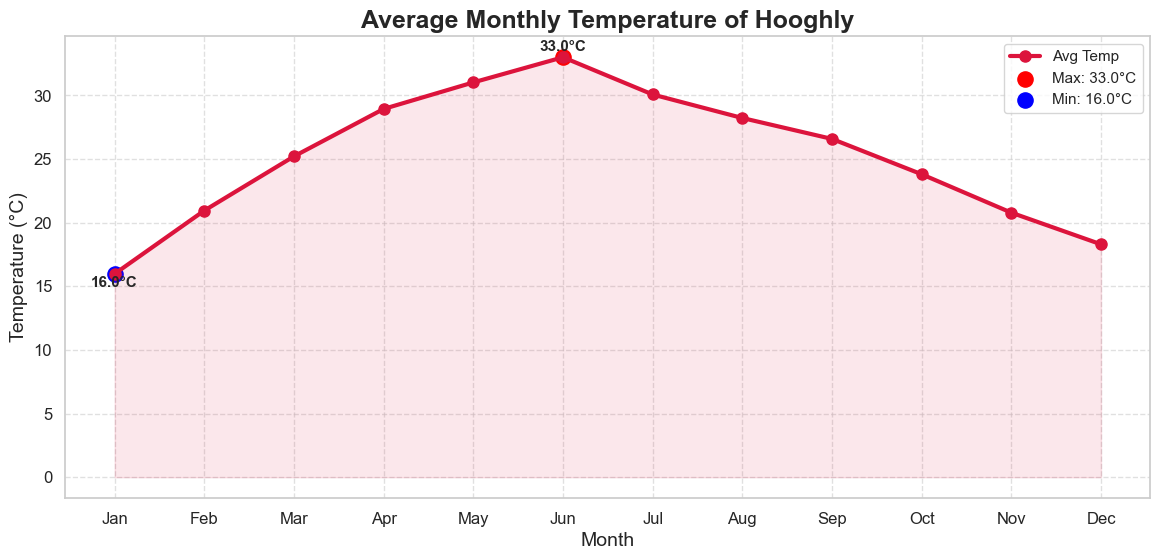

In [18]:
# ------------------------------------------------
# STEP 2: Plotting the monthly average temperature
# ------------------------------------------------

# Set Seaborn style for modern look
sns.set(style="whitegrid")
sns.set_palette("coolwarm")

# Calculate monthly average temperature
monthly_avg = df.groupby('MonthName')['Temperature'].mean()

# Ensure months are in calendar order
month_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
monthly_avg = monthly_avg.reindex(month_order)

# Create figure
plt.figure(figsize=(14,6))

# Plot line with markers
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', markersize=8, linewidth=3, linestyle='-', color='crimson', label='Avg Temp')

# Highlight maximum and minimum temperature points
max_temp = monthly_avg.max()
min_temp = monthly_avg.min()
max_month = monthly_avg.idxmax()
min_month = monthly_avg.idxmin()

plt.scatter(max_month, max_temp, color='red', s=120, label=f'Max: {max_temp:.1f}°C')
plt.scatter(min_month, min_temp, color='blue', s=120, label=f'Min: {min_temp:.1f}°C')

# Annotate max and min
plt.text(max_month, max_temp+0.5, f'{max_temp:.1f}°C', ha='center', fontsize=11, fontweight='bold')
plt.text(min_month, min_temp-1, f'{min_temp:.1f}°C', ha='center', fontsize=11, fontweight='bold')

# Optional: Add shaded area under the curve for visual appeal
plt.fill_between(monthly_avg.index, monthly_avg.values, color='crimson', alpha=0.1)

# Title, labels, grid, legend
plt.title("Average Monthly Temperature of Hooghly", fontsize=18, fontweight='bold')
plt.xlabel("Month", fontsize=14)
plt.ylabel("Temperature (°C)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

In [6]:
# ------------------------------------------------
# STEP 3: Prepare Features for Cyclic Model
# ------------------------------------------------

# Normalize DayNumber (1–366 → 0–1)
df['DayNorm'] = df['DayNumber'] / 365

# Cyclic features
df['Sin'] = np.sin(2 * np.pi * df['DayNorm'])
df['Cos'] = np.cos(2 * np.pi * df['DayNorm'])

# YearOffset (if you only have 1 year, this becomes 0)
df['YearOffset'] = df['Date'].dt.year - df['Date'].dt.year.min()

# Feature Matrix (3 inputs)
X = df[['Sin', 'Cos', 'YearOffset']]
y = df['Temperature']

# Train the model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [7]:
# -----------------------------------------
# STEP 4: Predict Smooth Curve (1–366 days)
# -----------------------------------------

smooth_days = np.linspace(1, 366, 366)
smooth_norm = smooth_days / 365

smooth_sin = np.sin(2 * np.pi * smooth_norm)
smooth_cos = np.cos(2 * np.pi * smooth_norm)

# Average year offset (good practice)
avg_offset = df['YearOffset'].mean()

X_smooth = np.column_stack([smooth_sin, smooth_cos, np.full_like(smooth_days, avg_offset)])
smooth_pred = model.predict(X_smooth)


C:\Users\RITTIK BANERJEE\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [28]:
# -------------------------------------
# STEP 5: Displaying the Predicted data
# -------------------------------------

df['Sin'] = np.sin(2 * np.pi * df['DayNumber'] / 365)
df['Cos'] = np.cos(2 * np.pi * df['DayNumber'] / 365)
df['YearOffset'] = df['Date'].dt.year - df['Date'].dt.year.min()

# Select only the columns you want to display
df_display = df[['Date', 'DayNumber', 'Temperature']].copy()

# Display all rows
pd.set_option('display.max_rows', None)
print(df_display)
pd.reset_option('display.max_rows')

          Date  DayNumber  Temperature
0   2024-12-01          1    18.525534
1   2024-12-02          2    18.671602
2   2024-12-03          3    20.376018
3   2024-12-04          4    20.912810
4   2024-12-05          5    18.476792
5   2024-12-06          6    19.766210
6   2024-12-07          7    15.464402
7   2024-12-08          8    19.415599
8   2024-12-09          9    16.607131
9   2024-12-10         10    18.561068
10  2024-12-11         11    20.038096
11  2024-12-12         12    18.265643
12  2024-12-13         13    18.028522
13  2024-12-14         14    19.597994
14  2024-12-15         15    21.093582
15  2024-12-16         16    18.053608
16  2024-12-17         17    18.072519
17  2024-12-18         18    19.153303
18  2024-12-19         19    16.233013
19  2024-12-20         20    14.622252
20  2024-12-21         21    16.523660
21  2024-12-22         22    16.534261
22  2024-12-23         23    18.563941
23  2024-12-24         24    18.275592
24  2024-12-25         25

In [29]:
# ------------------------
# STEP 6: Model Evaluation
# ------------------------

# Make sure the feature columns exist
df['Sin'] = np.sin(2 * np.pi * df['DayNumber'] / 365)
df['Cos'] = np.cos(2 * np.pi * df['DayNumber'] / 365)
df['YearOffset'] = df['Date'].dt.year - df['Date'].dt.year.min()

# Predictions using the model
df['Predicted'] = model.predict(df[['Sin', 'Cos', 'YearOffset']])

# Compute evaluation metrics
mae = mean_absolute_error(df['Temperature'], df['Predicted'])
mse = mean_squared_error(df['Temperature'], df['Predicted'])
rmse = np.sqrt(mse)
r2 = r2_score(df['Temperature'], df['Predicted'])

print("\n=== Cyclic Model Evaluation ===")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")



=== Cyclic Model Evaluation ===
MAE  : 1.6735
MSE  : 4.4109
RMSE : 2.1002
R²   : 0.8463


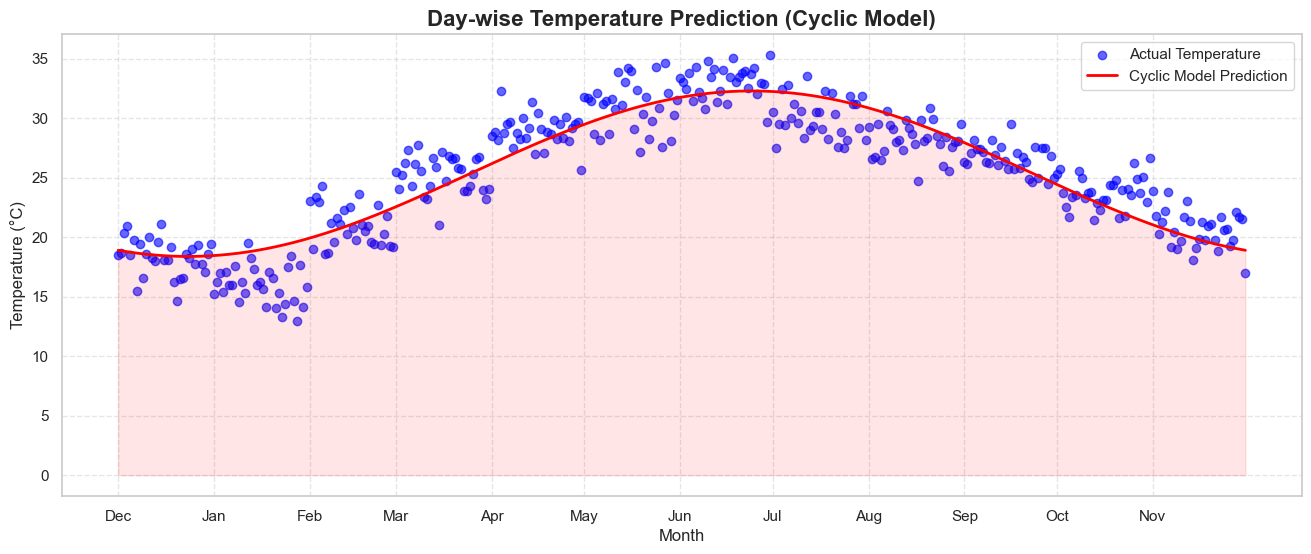

In [30]:
# ----------------------------------------------------
# STEP 7: Plotting the Predicted value vs Actual value
# ----------------------------------------------------

sns.set(style="whitegrid")
sns.set_palette("coolwarm")

plt.figure(figsize=(16,6))

# Scatter plot (Actual)
plt.scatter(df['DayNumber'], df['Temperature'],
            color='blue', alpha=0.6,
            label='Actual Temperature')

# Smooth Prediction Line
plt.plot(smooth_days, smooth_pred,
         color='red', linewidth=2,
         label='Cyclic Model Prediction')

# Shaded Prediction Area
plt.fill_between(smooth_days, smooth_pred,
                 color='red', alpha=0.1)

# Title & Labels
plt.title("Day-wise Temperature Prediction (Cyclic Model)", fontsize=16, fontweight='bold')
plt.ylabel("Temperature (°C)", fontsize=12)
plt.xlabel("Month", fontsize=12)

# X-axis Month Labels (same as your previous model)
month_ticks = df.groupby('Month')['DayNumber'].min()
month_labels = df.groupby('Month')['MonthName'].first()

plt.xticks(ticks=month_ticks, labels=month_labels, fontsize=11)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.show()

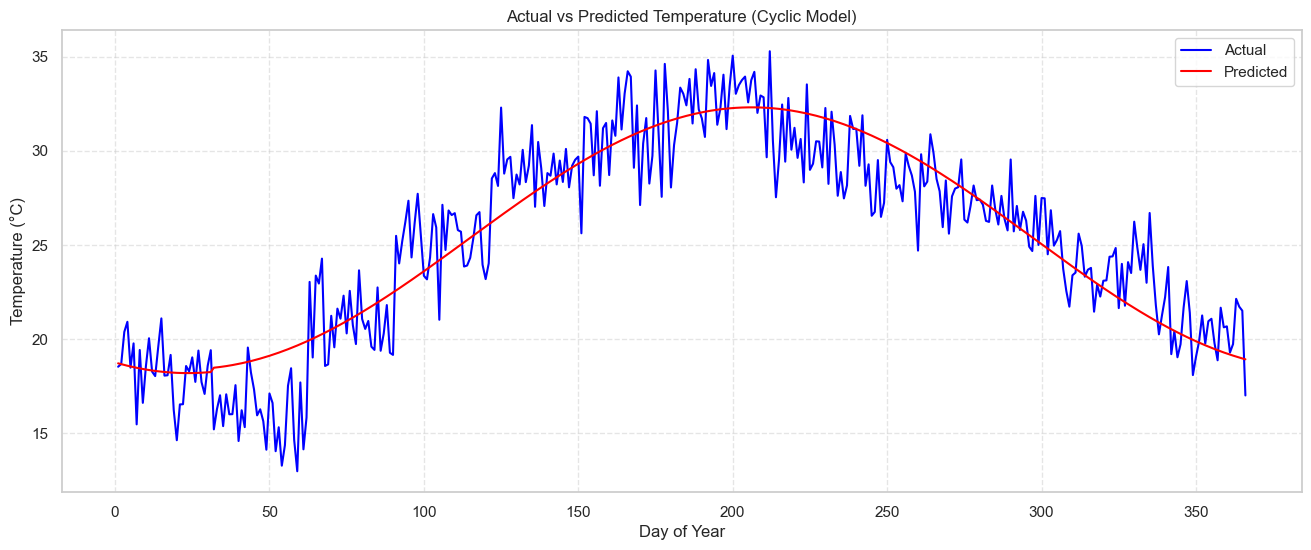

In [31]:
# ---------------------------------------------
# STEP 8: Prediction vs Actual Temperature Plot
# ---------------------------------------------

plt.figure(figsize=(16,6))
plt.plot(df['DayNumber'], df['Temperature'], label="Actual", color='blue')
plt.plot(df['DayNumber'], df['Predicted'], label="Predicted", color='red')
plt.title("Actual vs Predicted Temperature (Cyclic Model)")
plt.xlabel("Day of Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [44]:
# Converting date into day

def predict_temperature(date_str):
    date = pd.to_datetime(date_str)
    
    day_norm = date.dayofyear / 365
    sin_val = np.sin(2 * np.pi * day_norm)
    cos_val = np.cos(2 * np.pi * day_norm)

    year_offset = date.year - df["Date"].dt.year.min()

    X_new = np.array([[sin_val, cos_val, year_offset]])
    return model.predict(X_new)[0]


In [45]:
# Testing the model and trying to predict past and future temperatures

print(predict_temperature("2026-06-10"))
print(predict_temperature("2030-12-30"))
print(predict_temperature("2020-01-05"))

30.527466546827068
20.082522328200017
17.68606726472042


C:\Users\RITTIK BANERJEE\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\RITTIK BANERJEE\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\RITTIK BANERJEE\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
